In [1]:
import re

with open('files/ncf-nwws-nesdis.20191121-cs2-ancf') as file:
    ncf_file_contents = file.read()
    
with open('files/application.log.2019-11-21') as file:
    euc_file_contents = file.read()

In [2]:
ncf_regex= r"^\s.END (\d{2}/\d{2}/\d{4}) (\d{2}:\d{2}:\d{2}) WMO\[((\S{4}\d{2}) (\S{4}) (\d{6})( \S{3}|\s{4}|\*\* no CR))\] (\{(\S{4,6})\s{0,2}?\} )?\#(\d+)/\d+ bytes\((\d+)\) c\(\d+\) .*/P(\d)[\n\r]*"
euc_regex= r"^.*\[ArchiveController-Future\].*(\d\d\d\d\d\d\d\d\d\d\d\d\d\d-\d\d\d)\s(\w{4})\s(\w{6})\s(\w{4})\s(\d{6})\s(\w{3}(?:\s))?(\w{4,6})\s.*txt"

In [3]:
ncf_match = re.findall(ncf_regex, ncf_file_contents, re.MULTILINE)
euc_match = re.findall(euc_regex, euc_file_contents, re.MULTILINE)
#for item in match:
#    print(item)

In [4]:
import csv

with open('files/ncf-nwws-nesdis.20191118-cs2-ancf.csv','w') as file:
    writer = csv.writer(file, lineterminator='\n')
    val = [['date','time','wmo','cccc','createtime','nnnxxx','size']]
    for item in ncf_match:
        val.append([item[0], item[1], item[2], item[4], item[5], item[8], item[10]])
    writer.writerows(val)
    

with open('files/application.log.2019-11-18.csv','w') as file:
    writer = csv.writer(file, lineterminator='\n')
    val = [['date','time','wmo','cccc','createtime','nnnxxx']]
    for item in euc_match:
        # need to split into date and time
        val.append([item[0][0:8], item[0][8:],item[2], item[3], item[4], item[6]])
    writer.writerows(val)

In [5]:
from tinydb import TinyDB, Query
from tinydb.storages import MemoryStorage
db = TinyDB(storage=MemoryStorage)
products_table = db.table('products')
euc_table = db.table('euc')
cccc_table = db.table('cccc')
euc_cccc_table = db.table('euc_cccc')

#db = TinyDB('/home/warrick.moran/Downloads/drive-download-20200228T121647Z-001/db.json')
timedict = []
cccc = {}

for item in ncf_match: 
    timedict.append({'date':item[0],'time':item[1],'wmo':item[2],'cccc':item[4],'createtime':item[5],'nnnxxx':item[8],'size':item[10]})
    if item[4] not in cccc:
        cccc[item[4]] = 0
        cccc_table.insert({'cccc':item[4],'count':0})
        euc_cccc_table.insert({'cccc':item[4],'count':0})

products_table.insert_multiple(timedict)

del timedict
timedict = []

for item in euc_match:
    timedict.append({'date':item[0][0:8],'time':item[0][8:],'wmo':item[2],'cccc':item[3],'createtime':item[4],'nnnxxx':item[6]})

euc_table.insert_multiple(timedict)

print(products_table)
print(euc_table)

<Table name='products', total=36155, storage=<tinydb.database.StorageProxy object at 0x7fae090cfd50>>
<Table name='euc', total=22837, storage=<tinydb.database.StorageProxy object at 0x7fae182eac50>>


In [6]:
from tinydb import where

results = cccc_table.all()
for result in results:
    count = products_table.count(where('cccc') == result['cccc'])
    cccc_table.update({'count':count}, where('cccc') == result['cccc'])
    
del results
results = euc_cccc_table.all()

for result in results:
    euc_count = euc_table.count(where('cccc') == result['cccc'])
    euc_cccc_table.update({'count':euc_count}, where('cccc') == result['cccc'])
    
print(cccc_table)
print(euc_cccc_table)

<Table name='cccc', total=168, storage=<tinydb.database.StorageProxy object at 0x7fae00ea01d0>>
<Table name='euc_cccc', total=168, storage=<tinydb.database.StorageProxy object at 0x7fae00ea0350>>


<IPython.core.display.Javascript object>


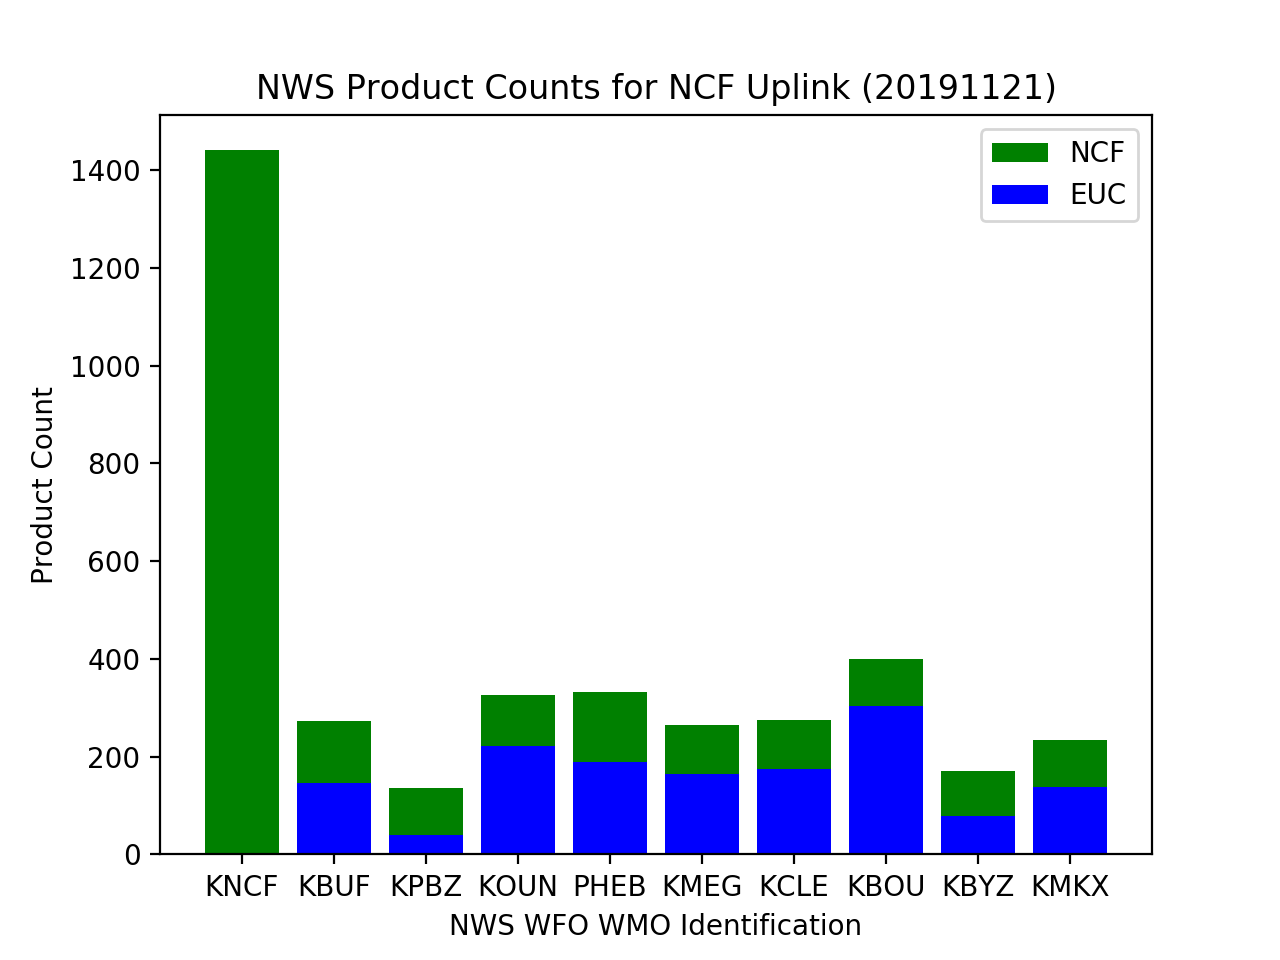

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

x = [] 
y = []

x1 = []
y1 = []

xy = cccc_table.all()

x1y1 = euc_cccc_table.all()

for cccc in xy[0:10]:
    x.append(cccc['cccc'])
    y.append(cccc['count'])

for cccc in x1y1[0:10]:
    x1.append(cccc['cccc'])
    y1.append(cccc['count'])
    

x_pos = [i for i, _ in enumerate(x)]

p1 = plt.bar(x_pos, y, color='green')
p2 = plt.bar(x_pos, y1, color='blue')

plt.xticks(x_pos, x)
plt.xlabel("NWS WFO WMO Identification")
plt.ylabel("Product Count")
plt.title("NWS Product Counts for NCF Uplink (20191121)")
plt.legend((p1[0], p2[0]), ('NCF', 'EUC'))
plt.show()
plt.savefig('files/ncf-nwws-nesdis.20191121-cs2-ancf.pdf')